In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Homework part I: Prohibited Comment Classification (3 points)

![img](https://github.com/yandexdataschool/nlp_course/raw/master/resources/banhammer.jpg)

__In this notebook__ you will build an algorithm that classifies social media comments into normal or toxic.
Like in many real-world cases, you only have a small (10^3) dataset of hand-labeled examples to work with. We'll tackle this problem using both classical nlp methods and embedding-based approach.

In [141]:
import pandas as pd
data = pd.read_csv("comments.tsv", sep='\t')

texts = data['comment_text'].values
target = data['should_ban'].values
data[50::200]

,should_ban,comment_text
50,0,"""Those who're in advantageous positions are th..."
250,1,Fartsalot56 says f**k you motherclucker!!
450,1,"Are you a fool? \n\nI am sorry, but you seem t..."
650,1,I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850,0,Citing sources\n\nCheck out the Wikipedia:Citi...


In [ ]:
# naive bayes 
# logistic regression BOW  --> logistic regression
# tf-idf
# word vector --> logistic regression

In [143]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

__Note:__ it is generally a good idea to split data into train/test before anything is done to them.

It guards you against possible data leakage in the preprocessing stage. For example, should you decide to select words present in obscene tweets as features, you should only count those words over the training set. Otherwise your algoritm can cheat evaluation.

### Preprocessing and tokenization

Comments contain raw text with punctuation, upper/lowercase letters and even newline symbols.

To simplify all further steps, we'll split text into space-separated tokens using one of nltk tokenizers.

In [4]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "fuck you" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),)

before: How to be a grown-up at work: replace "fuck you" with "Ok, great!".
after: how to be a grown-up at work : replace " fuck you " with " ok , great ! " .


In [145]:
def modify(x):
    text = []
    for row in x:
        row = preprocess(row)
        text.append(row)
    return text

texts_test = modify(texts_test)
texts_train = modify(texts_train)

In [146]:
assert texts_train[5] ==  'who cares anymore . they attack with impunity .'
assert texts_test[89] == 'hey todds ! quick q ? why are you so gay'
assert len(texts_test) == len(y_test)
print("success!")

success!


### Solving it: bag of words

![img](http://www.novuslight.com/uploads/n/BagofWords.jpg)

One traditional approach to such problem is to use bag of words features:
1. build a vocabulary of frequent words (use train data only)
2. for each training sample, count the number of times a word occurs in it (for each word in vocabulary).
3. consider this count a feature for some classifier

__Note:__ in practice, you can compute such features using sklearn. Please don't do that in the current assignment, though.
* `from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer`

In [382]:
UNK, PAD = "UNK", "PAD"
#bow_vocabulary.update({'UNK': 0})
#bow_vocabulary.update({'PAD': 0})
bow_vocabulary[PAD]

def pad(l, content, width):
    l.extend([content] * (width - len(l)))
    return l

def text_to_id(text, max_len=30):
    """ convert text string to an array of token counts. Use bow_vocabulary. """
    token_count = []
    text = text.split()
    
    # add padding
    if len(text) < max_len:
        text = pad(text, PAD, max_len)
    
    if len(text) > max_len:
        text = text[:max_len]    
    
    for word in text:
        if bow_vocabulary.get(word) == None:
            token_count.append(bow_vocabulary[UNK])
        else:
            token_count.append(bow_vocabulary[word])
    
    return np.array(token_count, 'float32')

text_to_id("hello is hello jhfhfhfh jfhfhfhf", max_len=30)

array([ 10., 657.,  10.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.], dtype=float32)

In [147]:
from collections import Counter
import tqdm

def count_dict(x):
    values = {}
    for row in x:
        vals = row.split()
        for val in vals:
            if val not in values:
                values[val] = 1
            else:
                values[val] += 1
    return values

In [148]:
# task: find up to k most frequent tokens in texts_train,
# sort them by number of occurences (highest first)
k = 10000

bow_vocabulary = count_dict(texts_train)
print(len(bow_vocabulary))
bow_vocabulary = dict(sorted(bow_vocabulary.items(), key=lambda item: item[1], reverse=True))

print('example features:', sorted(bow_vocabulary, reverse=False)[:20])

5707
example features: ['!', '"', '#', '#000', '#000000', '#084080', '#bad', '#f5fffa', '#ffffff', '#irsentience', '#k_', '#more', '#series', '#sourcing_claims_for_', '#surname', '#titleu', '$', '%', '&', "'"]


In [150]:
len(bow_vocabulary)
"hello how are you you " --> [1 x 5707]

5707

In [151]:
def text_to_bow(text):
    text = text.split()
    res = np.zeros(len(bow_vocabulary)) 
    list_bow_vocab = list(bow_vocabulary)
    for word in text:
        for i in range(len(bow_vocabulary)):
            if word == list_bow_vocab[i]:
                res[i] += 1
    return np.array(res, 'float32')         

In [152]:
X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

print(X_train_bow.shape)
print(X_test_bow.shape)

(500, 5707)
(500, 5707)


In [155]:
X_train_bow[3]

array([5., 4., 1., ..., 0., 0., 0.], dtype=float32)

In [156]:
k_max = len(set(' '.join(texts_train).split()))  # len of dict
print(X_train_bow.shape)

assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[6, list(bow_vocabulary.keys()).index(".")] == texts_train[6].split().count('.')

(500, 5707)


__Naive bayes:__ perhaps the simplest model that can solve your problem is the so called Naive Bayes Classifier. 
Its a trivial linear model that assumes the independence of input features and computes the coefficients by, well, counting probabilities.

If you don't remember the math behind Naive Bayes, read [this chunk](https://lena-voita.github.io/nlp_course/text_classification.html#naive_bayes) to help refresh your memory. Done? Good! Now let's implement that :)

[0 1] [261 239]


array([0.522, 0.478])

In [158]:
X_test_bow[0]

array([0., 0., 1., ..., 0., 0., 0.], dtype=float32)

In [192]:
def words_count(X, y):
    positive_set = np.zeros(len(bow_vocabulary)) #  [ 1 x 5707]
    negative_set = np.zeros(len(bow_vocabulary)) 
    
    for i in range(len(y)):
        if y[i] == 1:
            negative_set += X[i]
        else:
            positive_set += X[i]
    
    return positive_set, negative_set
            
a, b = words_count(X_train_bow, y_train)
print(a.shape)
print(b.shape)

(5707,)
(5707,)


In [191]:
def p_x_given_label(word_count, delta):
    assumption = []
    V = len(bow_vocabulary)
    for i in range(V):
        assumption.append((word_count[i] + delta) / (delta * V + np.sum(word_count)))
    return np.array(assumption, 'float32') 

pos_prob = p_x_given_label(a, 1)
pos_prob 

array([3.1053985e-02, 3.0642673e-02, 1.0351328e-02, ..., 3.4275919e-05,
       3.4275919e-05, 3.4275919e-05], dtype=float32)

In [190]:
unique, counts = np.unique(y_train, return_counts=True)
print(unique, counts)
np.array([counts[0]/len(y_train), counts[1]/len(y_train)])

[0 1] [261 239]


array([0.522, 0.478])

In [210]:
class BinaryNaiveBayes:
    
    def fit(self, X, y):
        """
        Fit a NaiveBayes classifier for two classes
        :param X: [batch_size, vocab_size] of bag-of-words features
        :param y: [batch_size] of binary targets {0, 1}
        """
        
        delta = 1.0  # add this to all word counts to smoothe probabilities
        
        # first, compute marginal probabilities of every class, p(y=k) for k = 0,1
        #self.p_y = np.array(<YOUR CODE: probability of y=0 and of y=1 in that order>)
        self.p_y = np.array([counts[0]/len(y), counts[1]/len(y)])
        
        # count occurences of each word in texts with label 1 and label 0 separately
        word_counts_positive, word_counts_negative = words_count(X, y)
        # ^-- both must be vectors of shape [vocab_size].
        
        # finally, lets use those counts to estimate p(x | y = k) for k = 0, 1
        self.p_x_given_positive = p_x_given_label(word_counts_positive, delta=delta)
        self.p_x_given_negative = p_x_given_label(word_counts_negative, delta=delta)
        # both must be of shape [vocab_size]; and don't forget to add self.delta!
        
        return self
    
    def predict_scores(self, X):
        """
        :param X: [batch_size, vocab_size] of bag-of-words features
        :returns: a matrix of scores [batch_size, k] of scores for k-th class
        """
        # compute scores for positive and negative classes separately.
        # these scores should be proportional to log-probabilities of the respective target {0, 1}
        # note: if you apply logarithm to p_x_given_*, the total log-probability can be written
        # as a dot-product with X
        
        #score_negative = <YOUR CODE HERE - compute unnormalized negative log-probability>
        #score_positive = <YOUR CODE HERE - compute positive negative log-probability>
        
        # how do i use np_log
        score_negative = np.log(self.p_y[0]) + np.expand_dims(np.log(self.p_x_given_negative), axis=0) @ X.T 
        score_positive = np.log(self.p_y[1]) + np.expand_dims(np.log(self.p_x_given_positive), axis=0) @ X.T
        
        # you can compute total p(x | y=k) with a dot product
        return np.squeeze(np.stack([score_positive, score_negative], axis=-1), axis=0)
    
    
    def predict(self, X):
        return self.predict_scores(X).argmax(axis=-1)

In [211]:
naive_model = BinaryNaiveBayes().fit(X_train_bow, y_train)

In [173]:
(naive_model.predict_scores(X_train_bow[:10]))

array([[0.02383219, 0.03015912],
       [0.643487  , 0.4360456 ],
       [0.04970406, 0.05729431],
       [0.28344554, 0.21031277],
       [0.1497563 , 0.13948092],
       [0.03635661, 0.02793624],
       [0.8836874 , 0.6061863 ],
       [0.08640062, 0.07243395],
       [0.1493448 , 0.13347313],
       [0.13052237, 0.1060175 ]], dtype=float32)

In [167]:
my_index = list(bow_vocabulary.keys()).index("good")

print("negative", naive_model.p_x_given_negative[my_index])
print("positive", naive_model.p_x_given_positive[my_index])

negative 0.0010282777
positive 0.0003770581


In [169]:
assert naive_model.p_y.shape == (2,) and naive_model.p_y.sum() == 1 and naive_model.p_y[0] > naive_model.p_y[1]
assert naive_model.p_x_given_positive.shape == naive_model.p_x_given_negative.shape == X_train_bow.shape[1:]
assert np.allclose(naive_model.p_x_given_positive.sum(), 1.0)
assert np.allclose(naive_model.p_x_given_negative.sum(), 1.0)
assert naive_model.p_x_given_negative.min() > 0, "did you forget to add delta?"

f_index = list(bow_vocabulary.keys()).index("fuck")# offensive tweets should contain more of this
assert naive_model.p_x_given_positive[f_index] > naive_model.p_x_given_negative[f_index]

g_index = list(bow_vocabulary.keys()).index("good") # offensive tweets should contain less of this
assert naive_model.p_x_given_positive[g_index] < naive_model.p_x_given_negative[g_index]

In [20]:
naive_model.predict_scores(X_train_bow).shape
naive_model.predict_scores(X_train_bow)[:, 0].shape

(500,)

## Get Accuracy

In [212]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

pred_train = naive_model.predict(X_train_bow)
pred_test = naive_model.predict(X_test_bow)

print("train acc", accuracy_score(y_train, pred_train))
print("test acc", accuracy_score(y_test, pred_test))

train acc 0.946
test acc 0.756


Model accuracy: 0.756
Well done!


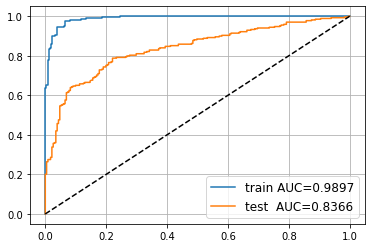

In [213]:
for name, X, y, model in [
    ('train', X_train_bow, y_train, naive_model),
    ('test ', X_test_bow, y_test, naive_model)
]:
    proba = model.predict_scores(X)[:, 1] - model.predict_scores(X)[:, 0]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

test_accuracy = np.mean(naive_model.predict(X_test_bow) == y_test)
print(f"Model accuracy: {test_accuracy:.3f}")
assert test_accuracy > 0.75, "Accuracy too low. There's likely a mistake in the code."
print("Well done!")

Okay, it definitely learned *something*. Now let's figure out what exactly it learned. The simplest way to do that is by highlighting which words have a greatest ratio of positive to negative probability or vice versa. We'll go with the negative one [because reasons](https://www.urbandictionary.com/define.php?term=because%20reasons).

__Your task__ is to compute top-25 words that have the __highest__ ratio of ${p(x_i | y=0)} \over {p(x_i | y=1)}$. Enjoy!

In [498]:
kk = (naive_model.p_x_given_negative / naive_model.p_x_given_positive)
ll

array([ 82.,  85.,  84.,  77., 141., 214., 235., 234.,  89., 278., 303.,
       339., 338., 336., 326., 318., 116., 119., 359., 357., 356., 175.,
       392., 390., 387.])

In [509]:
def make_struct(x):
    arr = []
    for i in range(x.shape[0]):
        arr.append([x[i], i])
    return np.array( sorted(arr, reverse=False)[:25])

array([ 16,  17,  21,  13,  35,  36,  39,  71, 105, 115, 130, 134, 181,
       208, 302,  12, 333, 337, 341, 179, 372, 380, 408, 424, 464])

In [513]:
# hint: use naive_model.p_*
#probability_ratio = <YOUR CODE: compute the ratio as defined above, must be a vector of [vocab_size]>
#top_negative_words = <YOUR CODE: find 25 words with highest probability_ratio, return list of str>

probability_ratio = naive_model.p_x_given_negative / naive_model.p_x_given_positive
ratio_struct = make_struct(probability_ratio)[:,1].astype(int)

top_negative_words = []
for word in ratio_struct:
    top_negative_words.append(list(list(bow_vocabulary.items())[word])[0])
    
#top_negative_words = <YOUR CODE: find 25 words with highest probability_ratio, return list of str>

assert len(top_negative_words) == 25 and [isinstance(w, str) for w in top_negative_words]
assert 'j.delanoy' in top_negative_words and 'college' in top_negative_words

for i, word in enumerate(top_negative_words):
    print(f"#{i}\t{word.rjust(10, ' ')}\t(ratio={probability_ratio[list(bow_vocabulary.keys()).index(word)]})")

#0	    hitler	(ratio=0.002103166887536645)
#1	      heil	(ratio=0.002119512762874365)
#2	   offfuck	(ratio=0.00226629339158535)
#3	      suck	(ratio=0.0031772113870829344)
#4	    nigger	(ratio=0.004470666404813528)
#5	 j.delanoy	(ratio=0.004545177333056927)
#6	      dick	(ratio=0.005347267724573612)
#7	      fggt	(ratio=0.010226649232208729)
#8	     bitch	(ratio=0.016696568578481674)
#9	      fuck	(ratio=0.018593907356262207)
#10	      shit	(ratio=0.02272588573396206)
#11	      slap	(ratio=0.02272588573396206)
#12	   fucking	(ratio=0.031466614454984665)
#13	       ass	(ratio=0.037187814712524414)
#14	    stupid	(ratio=0.05454212799668312)
#15	         =	(ratio=0.05701268091797829)
#16	         *	(ratio=0.05843799188733101)
#17	   college	(ratio=0.05843799188733101)
#18	   asshole	(ratio=0.06293322890996933)
#19	         u	(ratio=0.06545055657625198)
#20	   bastard	(ratio=0.06817765533924103)
#21	       hit	(ratio=0.06817765533924103)
#22	     idiot	(ratio=0.07437562942504883)
#23	     

Now lets try something less prehistoric: __Logistic Regression__. Turns out, if you're using silicon instead of an abacus, you can find model weights by optimizing the log-probability of the answer. Though, of course, you don't even need to write it by hand anymore. Let's sklearn it!

In [215]:
LogisticRegression?

In [219]:
from sklearn.linear_model import LogisticRegression

bow_model = LogisticRegression(random_state=16, C=0.2).fit(X_train_bow, y_train)
pred_test = bow_model.predict(X_test_bow)

print("test acc", accuracy_score(y_test, pred_test))

test acc 0.772


Model accuracy: 0.772
Well done!


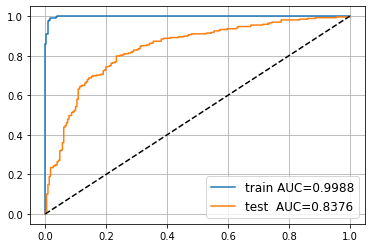

In [220]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, bow_model),
    ('test ', X_test_bow, y_test, bow_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

test_accuracy = np.mean(bow_model.predict(X_test_bow) == y_test)
print(f"Model accuracy: {test_accuracy:.3f}")
assert test_accuracy > 0.77, "Hint: tune the parameter C to improve performance"
print("Well done!")

### Task: implement TF-IDF features

Not all words are equally useful. One can prioritize rare words and downscale words like "and"/"or" by using __tf-idf features__. This abbreviation stands for __text frequency/inverse document frequence__ and means exactly that:

$$ feature_i = { Count(word_i \in x) \times { log {N \over Count(word_i \in D) + \alpha} }} $$


, where x is a single text, D is your dataset (a collection of texts), N is a total number of documents and $\alpha$ is a smoothing hyperparameter (typically 1). 
And $Count(word_i \in D)$ is the number of documents where $word_i$ appears.

It may also be a good idea to normalize each data sample after computing tf-idf features.

__Your task:__ implement tf-idf features, train a model and evaluate ROC curve. Compare it with basic BagOfWords model from above.

Please don't use sklearn/nltk builtin tf-idf vectorizers in your solution :) You can still use 'em for debugging though.

In [ ]:
- one hot encoding
- BOW
- TF-IDF
- word2vec
- Elmo 
- Bert
- GPT

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```


### Solving it better: word vectors

Let's try another approach: instead of counting per-word frequencies, we shall map all words to pre-trained word vectors and average over them to get text features.

This should give us two key advantages: (1) we now have 10^2 features instead of 10^4 and (2) our model can generalize to word that are not in training dataset.

We begin with a standard approach with pre-trained word vectors. However, you may also try
* training embeddings from scratch on relevant (unlabeled) data
* multiplying word vectors by inverse word frequency in dataset (like tf-idf).
* concatenating several embeddings
    * call `gensim.downloader.info()['models'].keys()` to get a list of available models
* clusterizing words by their word-vectors and try bag of cluster_ids

__Note:__ loading pre-trained model may take a while. It's a perfect opportunity to refill your cup of tea/coffee and grab some extra cookies. Or binge-watch some tv series if you're slow on internet connection

In [105]:
gensim.downloader.info()['models'].keys()

dict_keys(['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis'])

In [104]:
from gensim.models.word2vec import Word2Vec
import gensim.downloader 

embeddings = gensim.downloader.load("fasttext-wiki-news-subwords-300")

# If you're low on RAM or download speed, use "glove-wiki-gigaword-100" instead. Ignore all further asserts.

In [132]:
len(embeddings.key_to_index)
embeddings.key_to_index["hello"]
preprocess("let's").split()

13169

In [137]:
def vectorize_sum(comment):
    """
    implement a function that converts preprocessed comment to a sum of token vectors
    """
    embedding_dim = embeddings.vector_size
    features = np.zeros([embedding_dim], dtype='float32')
    
    comment = preprocess(comment)
    comment = comment.split(' ')
    
    for token in comment:
        if token in embeddings.key_to_index:
            token = embeddings.get_vector(token)
            features += token
          
    return features

print(vectorize_sum("who cares anymore . they attack with impunity .")[::70])
assert np.allclose(
    vectorize_sum("who cares anymore . they attack with impunity .")[::70],
    np.array([ 0.0108616 ,  0.0261663 ,  0.13855131, -0.18510573, -0.46380025])
)

[ 0.0108616   0.0261663   0.13855131 -0.18510573 -0.46380025]


In [138]:
X_train_wv = np.stack([vectorize_sum(text) for text in texts_train])
X_test_wv = np.stack([vectorize_sum(text) for text in texts_test])

In [139]:
wv_model = LogisticRegression(random_state=16).fit(X_train_wv, y_train)
pred_test = wv_model.predict(X_test_wv )

print("test acc", accuracy_score(y_test, pred_test))

test acc 0.884


/home/iris/paulshab/NLP_env/nlp_environ/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


/home/iris/paulshab/NLP_env/nlp_environ/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


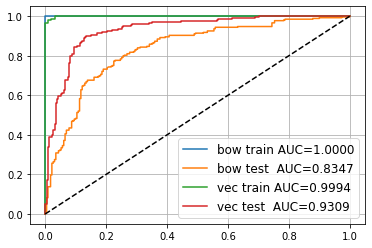

In [140]:
wv_model = LogisticRegression().fit(X_train_wv, y_train)

for name, X, y, model in [
    ('bow train', X_train_bow, y_train, bow_model),
    ('bow test ', X_test_bow, y_test, bow_model),
    ('vec train', X_train_wv, y_train, wv_model),
    ('vec test ', X_test_wv, y_test, wv_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

assert roc_auc_score(y_test, wv_model.predict_proba(X_test_wv)[:, 1]) > 0.92, "something's wrong with your features"

If everything went right, you've just managed to reduce misclassification rate by a factor of two.
This trick is very useful when you're dealing with small datasets. However, if you have hundreds of thousands of samples, there's a whole different range of methods for that. We'll get there in the second part.